<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/main/Input_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.stats as st
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal as ss

#Rhythmic Modulation

Setting parameters

In [2]:
#setting up mock population of presynaptic neurons

mean_fr = 10   # mean firing rate
std_fr = 2     # std firing rate

a, b = (0 - mean_fr) / std_fr, (100 - mean_fr) / std_fr  #End points for the truncated normal distribution
print('a = ',a)
print('b = ',b)

a =  -5.0
b =  45.0


In [3]:
d = partial(st.truncnorm.rvs, a=a, b=b, loc=mean_fr, scale=std_fr)

# Creating a function to sample from a simulated population of cells with
# Truncated Normal distribution
# mean firing rate = 10
# Std of firing rate = 2
# bounds of -5.0 and 45

In [4]:
def modulateSimSpikes(n_cells,f,depth_of_mod):
  frs = d(size=n_cells) # Calling st.truncnorm.rvs to sample from simulated cells
                      # Sample size = n_cells = 1000


  t = np.arange(0,t_stop,0.001)
    # t is an array with values ranging from 0 to t_stop with increment 0.001
  z = np.zeros((n_cells,t.shape[0]))
    # Z is a n_cells by t.shape[0] ([1000][100]) matrix of 0's

  P = 0
   #Phase of sine wave

  #Loop through each cell
  for i in np.arange(0,n_cells):

    offset = frs[i] #Set 'offest' to the firing rate of cell i

    mod_trace =  offset * (1 + depth_of_mod * np.sin((2 * np.pi * f * t ) + P))  #set the modulated firing rate values for cell i
        # (2 * np.pi * f * t) :  an array of size t
        # np.sin(  )          :  takes the sine of each value of the above array
        # depth_of_mod = 0 (no modulation)   -->  mod_trace = offset
        # depth_of_mod = 1 (full modulation) -->  mod_trace = offset + (offset * (np.sin((2 * np.pi * f * t ) + P)))


          #The above is algebrically equivalent to the following

              # offset + (offset * depth_of_mod * np.sin((2 * np.pi * f * t ) + P))

          #And to:

              # A = offset * (np.sin((2 * np.pi * f * t ) + P) + 1)     #Setting the modulated term
              # B = offset                                              #Setting the constant term
              # mod_trace = depth_of_mod*A + (1-depth_of_mod)*B         #Adding their components

    z[i,:] = mod_trace
        # z[i,:] is the instantanous firing rate of cell i
        # Set the ith row of z to an array of firing rates for each time step




  return z

Generate spikes with firing rates at each time step set bt z

In [5]:
def samplePoissonRVS(z):
#---
#   The Poisson distribution is a discrete probability distribution that expresses the probability of a
#   given number of events occurring in a fixed interval of time or space if these events occur with a
#   known constant mean rate and independently of the time since the last event.
#
#   An unmodulated cell has a constant mean firing rate, but as modulation causes the firing rate to
#   change over time (phase) we consider each small time interval (as determined by length of the timestep)
#   where the firing rate is constant.
#
#   For a given cell i and a given timestep t we model how many times cell i fires during timestep t
#   using the poisson distribution with λ being set to the firing rate for cell i at time t (adjusted
#   to be the firing rate per milisecond, i.e. per timstep).
#
#   For a given cell this results in many timesteps that do not have spikes - but apoximatly 10 spikes every 1000 timesteps

  simSpks = []

  #Loop through each cell

  for i in np.arange(0,n_cells):

    r = z[i,:]

    r[r<0] = 0 #Can't have negative firing rates.


    numbPoints = scipy.stats.poisson(r/1000).rvs()
      # numbPoints is an array of poisson random varibles with length of array = # of time steps
      # Each random variable is a poisson disribution that models the number of spikes that occur for cell i during the interval of each timestep
      # At each timestep t, cell i has a new freqency value given by z[i,t]
        # The poisson random variable that models the number of spikes that occur in cell i at timestep t has the parameter λ = Z[i,t]/1000

    simSpks.append(np.where(numbPoints>0)[0])
      # If a spike occurs for cell i at timestep t, append timestep t to simSpks
      # i.e. if the poisson random variable for cell i at timestep t takes a value of 1 then 't' will be appended to simSpks

  return simSpks

Ploting

In [6]:
# plt.plot(z[0,:])
# plt.plot(z[1,:])
# plt.plot(z[2,:])
# plt.plot(z[3,:])
# plt.xlim(0,100)

In [7]:
import numpy as np

def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

#Depth of modulation


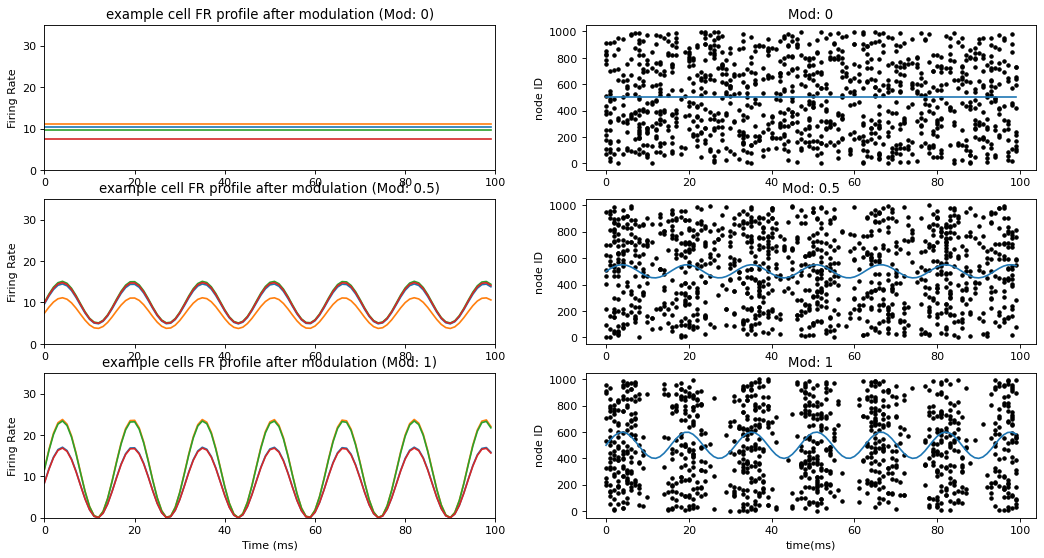

In [8]:
from matplotlib.pyplot import figure

#cols = ['Column {}'.format(col) for col in range(1, 2)]
#rows = ['Depth of mod = {}'.format(row) for row in ['0', '0.5', '1']]

figure(figsize=(16, 8), dpi=80)

# Depth of modulation  =  0

t_stop = 0.1 #seconds
n_cells = 1000
depth_of_mod = 0 # depth of modulation #define
f = 64 # frequency of oscillation (Gamma inhibition)
z = modulateSimSpikes(n_cells,f,depth_of_mod)

plt.subplot(3, 2, 1)
plt.plot(z[0,:])
plt.plot(z[1,:])
plt.plot(z[2,:])
plt.plot(z[3,:])
plt.xlim(0,100)
plt.ylim(0,35)
# plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
plt.title("example cell FR profile after modulation (Mod: "+str(depth_of_mod)+")")

plt.subplot(3, 2, 2)
raster = samplePoissonRVS(z)
for i in np.arange(0,z.shape[0]):
    plt.plot(raster[i],np.ones((raster[i].shape[0]))*i,'k.')
t = np.arange(0,t_stop,0.001)
plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500)
# plt.xlabel('time(ms)')
plt.ylabel('node ID')
plt.title("Mod: "+str(depth_of_mod))


# Depth of modulation  =  0.5

t_stop = 0.1 #seconds
n_cells = 1000
depth_of_mod = 0.5 # depth of modulation #define
f = 64 # frequency of oscillation (Gamma inhibition)
z = modulateSimSpikes(n_cells,f,depth_of_mod)

plt.subplot(3, 2, 3)
plt.plot(z[0,:])
plt.plot(z[1,:])
plt.plot(z[2,:])
plt.plot(z[3,:])
plt.xlim(0,100)
plt.ylim(0,35)
# plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
plt.title("example cell FR profile after modulation (Mod: "+str(depth_of_mod)+")")

plt.subplot(3, 2, 4)
raster = samplePoissonRVS(z)
for i in np.arange(0,z.shape[0]):
    plt.plot(raster[i],np.ones((raster[i].shape[0]))*i,'k.')
t = np.arange(0,t_stop,0.001)
plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500)
# plt.xlabel('time(ms)')
plt.ylabel('node ID')
plt.title("Mod: "+str(depth_of_mod))


# Depth of modulation  =  1

t_stop = 0.1 #seconds
n_cells = 1000
depth_of_mod = 1 # depth of modulation #define
f = 64 # frequency of oscillation (Gamma inhibition)
z = modulateSimSpikes(n_cells,f,depth_of_mod)

plt.subplot(3, 2, 5)
plt.plot(z[0,:])
plt.plot(z[1,:])
plt.plot(z[2,:])
plt.plot(z[3,:])
plt.xlim(0,100)
plt.ylim(0,35)
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate')
plt.title("example cells FR profile after modulation (Mod: "+str(depth_of_mod)+")")

plt.subplot(3, 2, 6)
raster = samplePoissonRVS(z)
for i in np.arange(0,z.shape[0]):
    plt.plot(raster[i],np.ones((raster[i].shape[0]))*i,'k.')
t = np.arange(0,t_stop,0.001)
plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500)
plt.xlabel('time(ms)')
plt.ylabel('node ID')
plt.title("Mod: "+str(depth_of_mod))


plt.show()

<Figure size 1920x640 with 0 Axes>

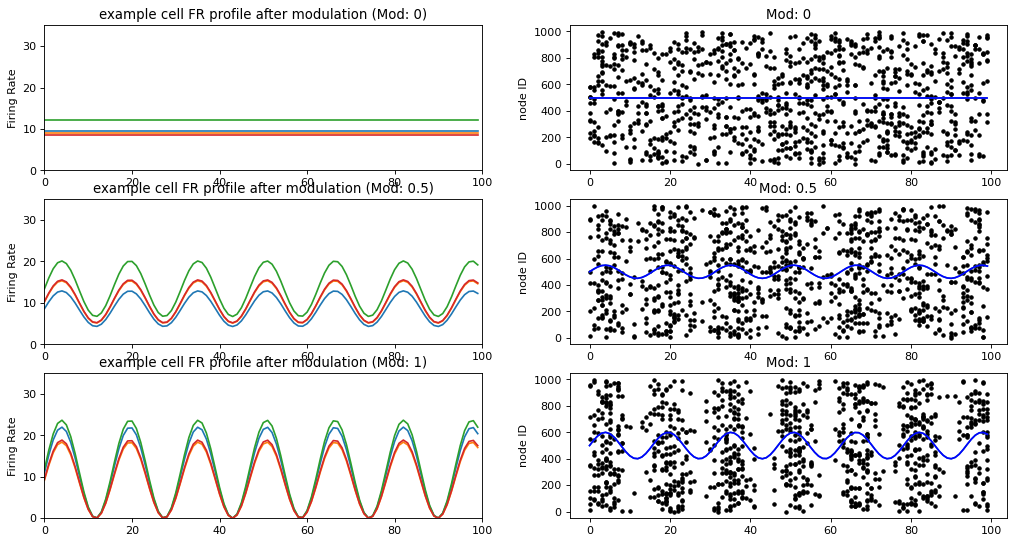

In [9]:
from matplotlib.pyplot import figure

figure(figsize=(24, 8), dpi=80)  # Changed figure size to accommodate 3 columns

# # Function to plot the binned spikes
# def plot_binned_spikes(raster, bin_size):
#     bin_counts = [len([t for t in cell_raster if t >= bin_start and t < bin_start + bin_size])
#                   for bin_start in range(0, int(t_stop*1000), bin_size)]
#     plt.bar(range(0, int(t_stop*1000), bin_size), bin_counts, width=bin_size, color='g', alpha=0.5)

# Function to plot the binned spikes for a single cell
def plot_binned_spikes_for_cell(cell_raster, bin_size):
    bin_counts = [len([t for t in cell_raster if t >= bin_start and t < bin_start + bin_size])
                  for bin_start in range(0, int(t_stop*1000), bin_size)]
    plt.bar(range(0, int(t_stop*1000), bin_size), bin_counts, width=bin_size, color='g', alpha=0.5)

figure(figsize=(24, 8), dpi=80)  # Changed figure size to accommodate 3 columns

# Loop through all depth_of_mod values

t_stop = 0.1 #seconds
n_cells = 1000
f = 64 # frequency of oscillation (Gamma inhibition)

for idx, depth_of_mod in enumerate([0, 0.5, 1]):

    # get fr profiles combined with mean firing rates
    z = modulateSimSpikes(n_cells,f,depth_of_mod)

    # plot fr profiles
    plt.subplot(3, 3, 3*idx + 1)
    plt.plot(z[0,:])
    plt.plot(z[1,:])
    plt.plot(z[2,:])
    plt.plot(z[3,:])
    plt.xlim(0,100)
    plt.ylim(0,35)
    # plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate')
    plt.title("example cell FR profile after modulation (Mod: "+str(depth_of_mod)+")")

    # plot raster
    plt.subplot(3, 3, 3*idx + 2)
    raster = samplePoissonRVS(z)
    for i in np.arange(0,z.shape[0]):
        plt.plot(raster[i],np.ones((raster[i].shape[0]))*i,'k.')
    t = np.arange(0,t_stop,0.001)
    plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500)
    # plt.xlabel('time(ms)')
    plt.ylabel('node ID')
    plt.title("Mod: "+str(depth_of_mod))

    t = np.arange(0, t_stop, 0.001)
    plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500, 'b')

    # plt.subplot(3, 3, 3*idx + 3)
    # plot_binned_spikes(raster, 10)  # Assuming bin_size is 10 ms
    # plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500, 'b')
    # plt.ylabel('Binned Spike Counts')
    # plt.title(f"Mod: {depth_of_mod}, Binned")
    # plot_binned_spikes_for_cell(raster[0], 10)  # Assuming bin_size is 10 ms
    # plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500, 'b')
    # plt.ylabel('Binned Spike Counts')
    # plt.title(f"Mod: {depth_of_mod}, Binned")

plt.show()


A single rhythmic input can be modeled by a sinusoid where the amplitude is the instantaneous firing rate. Sampling a poisson distribution according to the amplitude of the sinusoid at every time index will move events away from the  the timing of the sinusoid's trofts toward the timing of the sinusoid's peaks.

A gaussian distribution is often used to model inputs from a brain region. To model a population's rhythmic activity given this gaussian distribution, we can simply simple the gaussian for each cell and set the cell's firing rate to be a sinusoid that oscillates around the gaussian sampled firing rate, preserving the individual cell's mean firing rate.

Depth of modulation is a parameter that modifys the amplitude of the sinusoid to control the level of synchrony.

In [10]:
print(raster)

[array([21, 32, 49]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([82]), array([ 8, 20]), array([79]), array([22, 53]), array([10, 77]), array([20, 34]), array([94]), array([ 5, 31]), array([0]), array([35]), array([99]), array([], dtype=int64), array([93]), array([], dtype=int64), array([68]), array([], dtype=int64), array([69]), array([23]), array([18]), array([32]), array([20]), array([22, 52]), array([], dtype=int64), array([ 5, 31, 78]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([ 6, 41]), array([], dtype=int64), array([32]), array([], dtype=int64), array([35, 51]), array([], dtype=int64), array([78]), array([35]), array([ 3, 99]), array([65, 66]), array([52, 86]), array([22, 23, 41]), array([66, 97]), array([66]), array([69]), array([], dtype=int64), array([50]), array([ 4, 55]), array([36]), array([81]), array([], dtype=int64), array([67, 72]), array([ 0, 79, 99]), array([], dtype=int64

In [11]:

# spikes_at_t = np.zeros((n_cells,t.shape[0]))
# fr_at_t = np.zeros(t.shape[0])


# for j in np.arange(0,t.shape[0]):
#   for i in np.arange(0,n_cells):
#     #spikes_at_t = np.count_nonzero()
#     spikes_at_t[i,j] += raster[i,j]

#   fr_at_t[j] = spikes_at_t[i,j] / 1000


# # avg = (totalSpks/1000)* (1/t_stop)
# # print(avg)


#We verify that the arverage firing rate is unchanged after modulation

In [12]:
# def minmax(x):
#     """min max normalizes the given array"""
#     return (x - np.min(x))/(np.max(x)-np.min(x))

In [13]:
# def make_pink_noise(num_traces=100,num_samples=4999):
#     """
#     Modulates a generated gausian white noise trace to create pink noise.

#     Parameters
#     ----------
#     num_traces : int, optional
#         number of noise traces to create (first dimension), by default 100
#     num_samples : int, optional
#         length of the trace (second dimension), by default 4999
#     Returns
#     -------
#     np.array
#         noise trace
#     """

#     # Pink noise or ``1/f noise'' is an interesting case because there is no exact (rational, finite-order) filter which can produce it from white noise.
#     # This is because the ideal amplitude response of the filter must be proportional to the irrational function  1 / sqrt(f) , where f denotes frequency in Hz.
#     # However, it is easy enough to generate pink noise to any desired degree of approximation

#     #The following code generates pretty good pink noise:

#     B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]  #The coefficient A, B determines a filter that converts white noise to 1/f spectrum.
#     A = [1, -2.494956002,   2.017265875,  -0.522189400]         #You can use this function to check the frequency response of the filter, which should give you a 1/f amplitude response.

#     invfn = np.zeros((num_traces,num_samples))
#     for i in np.arange(0,num_traces):
#         wn = np.random.normal(loc=1, scale=0.5, size=num_samples+2000)      # Generate Gausian white noise
#         invfn[i,:] = wn[2000:]
#         invfn[i,:] = minmax(ss.lfilter(B, A, wn)[2000:])+0.5                # Filtering white noise to create a close approximation of '1/f' Noise
#                                                                             # The filtered signal is pink noise with 0 mean.
#                                                                             # The minmax function normalizes the signal to have values between [0,1].
#                                                                             # Adding 0.5 to it makes it positive and have mean 1, since firing rate cannot be negative
#     return invfn




# # One drawback of this method is that the variance of the generated firing rate is random due to the minmax normalization,
# # pretty much depending on the length of the generated signal.
# # A better approach may be to choose a scaling factor that controls the variance of the generated pink noise and add 1 to it after scaling it to make it have mean 1.
# # The scaling should make the pink noise magnitude rarely be greater than 1. But if such value occurs, set it to the closest bound of [-1, 1].


In [14]:
# pinkNoise = make_pink_noise(1000, 10)


# figure(figsize=(12, 8), dpi=80)
# for i in np.arange(0,pinkNoise.shape[0]):
#     plt.plot(pinkNoise[i],np.ones((pinkNoise[i].shape[0]))*i,'k.')
# t = np.arange(0,t_stop,0.001)
# #plt.plot(100*depth_of_mod*np.sin(2 * np.pi * f * t)+500)
# plt.xlabel('time(ms)')
# plt.ylabel('node ID')

# 1/f Noise Modulation

Now to simulate a NEURON cell with input

In [15]:
# install neuron simulator
!pip install neuron

In [16]:
# clone github repo
# !git clone https://github.com/davidfague/Neural-Modeling.git

In [17]:
# clone cell inference repo dependencies
# !git clone https://github.com/chenziao/Stylized-Single-Cell-and-Extracellular-Potential.git

In [18]:
%cd Neural-Modeling

[Errno 2] No such file or directory: 'Neural-Modeling'
/home/drfrbc/Neural-Modeling/notebooks


In [19]:
import os

In [20]:
from neuron import h

--No graphics will be displayed.


In [29]:
!pwd

/home/drfrbc/Neural-Modeling/notebooks


In [22]:
# import scripts.constants as constants

In [23]:
# from Modules.complex_cell import build_L5_cell

In [24]:
# # Compile and load modfiles
# os.system(f"nrnivmodl modfiles")
# h.load_file('stdrun.hoc')
# h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')

In [25]:
# complex_cell = build_L5_cell(cell_folder="complex_cells/L5PC/", biophys="L5PCbiophys3.hoc")

In [ ]:
# move cell_inference to Neural-Modeling directory
# %mv /content/Stylized-Single-Cell-and-Extracellular-Potential/cell_inference /content/Neural-Modeling

mv: cannot stat '/content/Stylized-Single-Cell-and-Extracellular-Potential/cell_inference': No such file or directory


In [32]:
# import classes from modules
import sys
sys.path.append("../")
from Modules.spike_generator import PoissonTrainGenerator
# from Modules.synapse_generator import SynapseGenerator

In [33]:
# create instances of the classes
spikegen = PoissonTrainGenerator()
# spikegen = SpikeGenerator()
# syngen = SynapseGenerator()

In [34]:
# initialize parameters

# random seed
numpy_random_state=123
random_state = np.random.RandomState(numpy_random_state)
np.random.seed(numpy_random_state)

# time vector for spike trains
tstart=0
tstop=100
dt=0.1
t=np.arange(tstart,tstop,dt)

In [38]:
#generate a firing rate profile
# fr_profile = spikegen.get_firing_rate_profile(t=t,method='1f_noise', random_state=random_state)
fr_profile = spikegen.generate_pink_noise(random_state,len(t))

# calls this function for reference:

# def noise_modulation(self, random_state: np.random.RandomState,
#                 num_obs: int, A: list = None, B: list = None,
#             bounds: tuple = (0.5, 1.5)) -> np.ndarray:
#   '''
#   Produce pink ("1/f") noise out of the white noise.
#   The idea is to generate a white noise and then filter it to impose autocovariance structure with
#   1/f psd. The filter used here is the scipy.signal's FIR / IIR filter which replaces observation t
#   with an AR(k) sum of the previous k unfiltered AND filtered observations.

#   The resulting pink noise is minmaxed and shifted to be in [shift[0], shift[1]] region.

#   Parameters:
#   ----------
#   num_obs: int
#     Length of the profile.

#   A: list[float]
#     AR coefficients of the filtered observations.

#   B: list[float]
#     AR coefficients of the unfiltered (original) observations.

#   bounds: tuplew
#     The profile bounds: [min, max].

#   Returns:
#   ----------
#   fr_profile: np.ndarray
#     Firing rate profile.
#   '''
#   # Default values from a previous implementation.
#   if A is None:
#     A = [1, -2.494956002, 2.017265875, -0.522189400]
#   if B is None:
#     B = [0.049922035, -0.095993537, 0.050612699, -0.004408786]

#   white_noise = random_state.normal(loc = 1, scale = 0.5, size = num_obs + 2000)

#   # Apply the FIR/IIR filter to create the 1/f noise, minmax and shift to bounds
#   fr_profile = minmax(lfilter(B, A, white_noise)[2000:]) * (bounds[1] - bounds[0]) + bounds[0]

#   return fr_profile

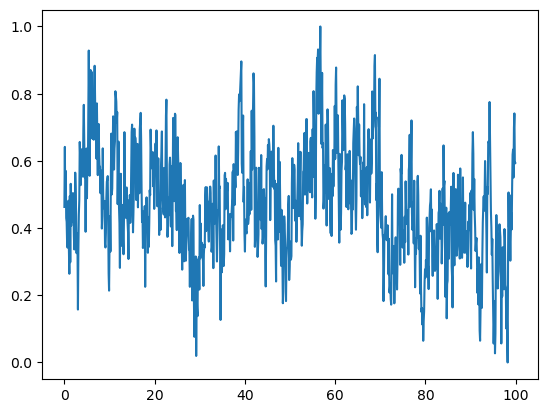

In [39]:
plt.plot(t,fr_profile)

The firing rate profile is normalized between some bounds. Here it is [0.5, 1.5].

In [ ]:
# combine modulatory trace with presynaptic cell mean firing rate
# spikes = spikegen.generate_spikes_from_profile(fr_profile, mean_fr, random_state)
# spikes = spikes*dt # convert from timestamps to ms
# print(spikes)

# def generate_spikes_from_profile(self, fr_profile: np.ndarray, mean_fr: float, random_state: np.random.RandomState) -> np.ndarray:
#   '''
#   sample from a poisson distribution representing the instantaneous firing rate at each time point to generate a spike train.
#   '''
#   fr_profile = fr_profile * mean_fr
#   sample_values = random_state.poisson(fr_profile / 1000)
#   spike_times = np.where(sample_values > 0)[0]
#   return spike_times

fr_profile = spikegen.shift_mean_of_lambdas(fr_profile, mean_fr, logger=None)
spikes = spikegen.generate_spike_train(fr_profile, random_state)
spikes = spikes.spike_times*dt # get times and convert from timestamp to ms

In [ ]:
# plt.plot(t,fr_profile)
# plt.scatter(spikes,[1.5 for i in spikes], color='red')

In [44]:
# sample lots of spike trains
spike_trains=[]
num_spike_trains=10000
for i in range(num_spike_trains):
  # spikes = spikegen.generate_spikes_from_profile(fr_profile, mean_fr, random_state)
  # spikes = spikes*dt # convert from timestamps to ms
  spikes = spikegen.generate_spike_train(fr_profile, random_state)
  spikes = spikes.spike_times*dt # get times and convert from timestamp to ms
  spike_trains.append(spikes)



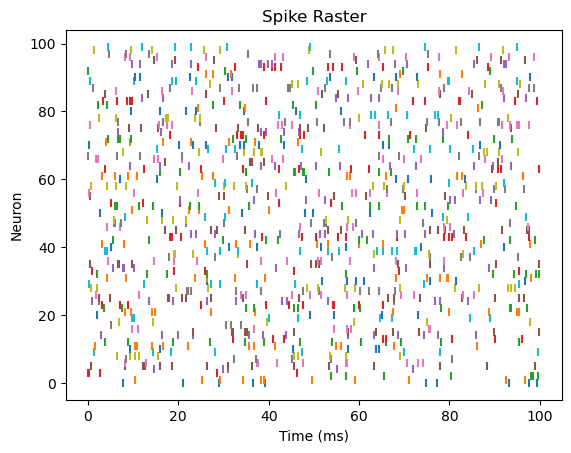

In [45]:
number_to_plot = 100  # Replace this with the number of cells you want to plot

for i, spikes in enumerate(spike_trains):
    if i >= number_to_plot:  # Stop plotting after the first x cells
        break
    plt.scatter(spikes, [i for spike in spikes], marker='|')

plt.xlabel("Time (ms)")
plt.ylabel("Neuron")
plt.title("Spike Raster")
plt.show()


Now to plot the spike trains in a histogram with bin_size dt

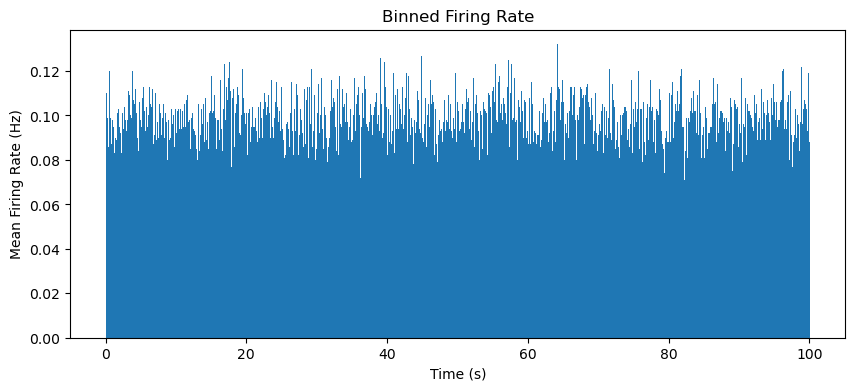

In [46]:
# Parameters for binning
bin_size = dt  # in seconds
num_bins = int(np.ceil(tstop / bin_size))

# Initialize an array to store binned spike counts
binned_spikes = np.zeros((num_spike_trains, num_bins))

# Bin the spikes
for i, spikes in enumerate(spike_trains):
    spike_counts, _ = np.histogram(spikes, bins=np.linspace(0, tstop, num_bins + 1))
    binned_spikes[i, :] = spike_counts

# Compute the mean firing rate across neurons
mean_firing_rate = np.mean(binned_spikes, axis=0) / bin_size

# Plot the binned firing rate
plt.figure(figsize=(10, 4))
plt.bar(np.linspace(0, tstop, num_bins), mean_firing_rate, width=bin_size, align='edge')
plt.xlabel("Time (s)")
plt.ylabel("Mean Firing Rate (Hz)")
plt.title("Binned Firing Rate")
plt.show()


Now to compare Binned firing rates with the original fr profile

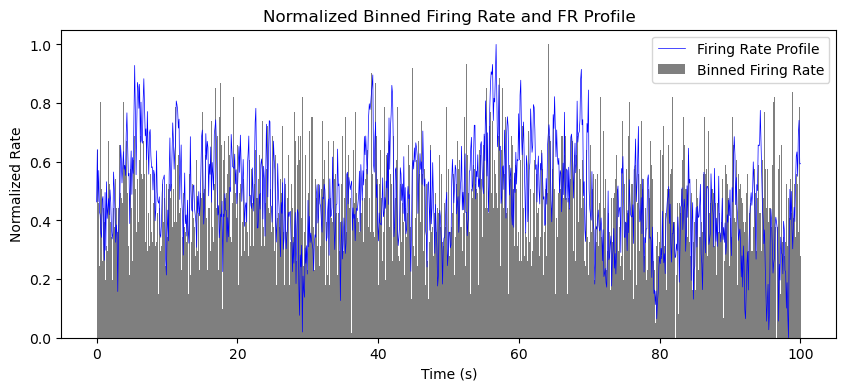

In [47]:
# Normalize the fr_profile and mean_firing_rate to [0, 1]
norm_fr_profile = (fr_profile - np.min(fr_profile)) / (np.max(fr_profile) - np.min(fr_profile))
norm_mean_firing_rate = (mean_firing_rate - np.min(mean_firing_rate)) / (np.max(mean_firing_rate) - np.min(mean_firing_rate))

# Plot the binned firing rate
plt.figure(figsize=(10, 4))
plt.bar(np.linspace(0, tstop, num_bins), norm_mean_firing_rate, width=bin_size, align='edge', alpha=0.5, label='Binned Firing Rate', color='black')
plt.plot(np.linspace(0, tstop, num_bins), norm_fr_profile, linewidth=0.5, label='Firing Rate Profile', color='blue')
plt.xlabel("Time (s)")
plt.ylabel("Normalized Rate")
plt.title("Normalized Binned Firing Rate and FR Profile")
plt.legend()
plt.show()


Now to plot the PSD of both

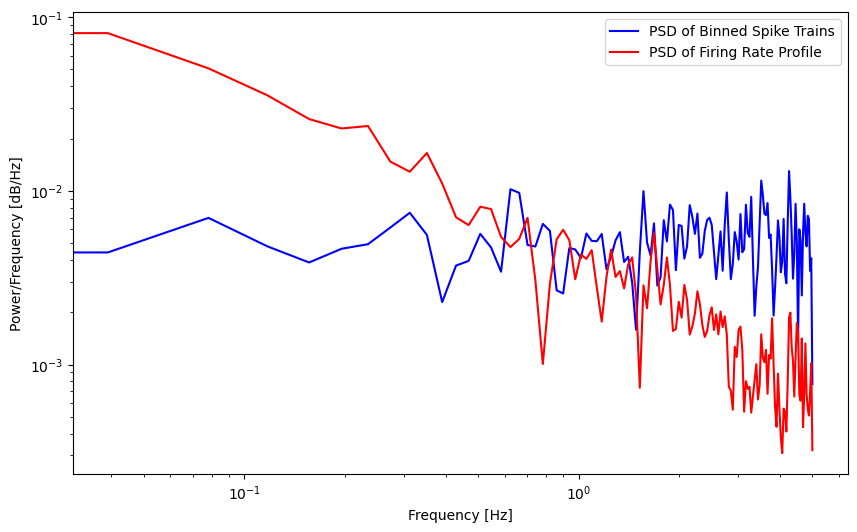

In [48]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Make sure that the nperseg parameter is smaller than or equal to the length of your data arrays
nperseg_value = min(256, len(norm_mean_firing_rate), len(norm_fr_profile))

# Compute the PSDs
frequencies1, psd_mean_firing_rate = signal.welch(norm_mean_firing_rate, fs=1/bin_size, nperseg=nperseg_value)
frequencies2, psd_fr_profile = signal.welch(norm_fr_profile, fs=1/bin_size, nperseg=nperseg_value)

# Make sure frequencies1 and frequencies2, and psd_mean_firing_rate and psd_fr_profile have the same lengths
assert len(frequencies1) == len(frequencies2)
assert len(psd_mean_firing_rate) == len(psd_fr_profile)

# Now plot
plt.figure(figsize=(10, 6))
plt.loglog(frequencies1, psd_mean_firing_rate, label='PSD of Binned Spike Trains', color='b')
plt.loglog(frequencies2, psd_fr_profile, label='PSD of Firing Rate Profile', color='r')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.legend()
plt.show()

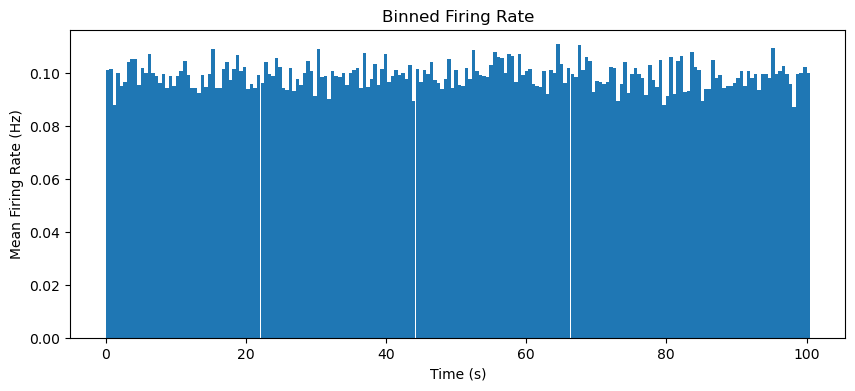

In [49]:
# Parameters for binning
bin_size = 0.5  # in seconds
num_bins = int(np.ceil(tstop / bin_size))

# Initialize an array to store binned spike counts
binned_spikes = np.zeros((num_spike_trains, num_bins))

# Bin the spikes
for i, spikes in enumerate(spike_trains):
    spike_counts, _ = np.histogram(spikes, bins=np.linspace(0, tstop, num_bins + 1))
    binned_spikes[i, :] = spike_counts

# Compute the mean firing rate across neurons
mean_firing_rate = np.mean(binned_spikes, axis=0) / bin_size

# Plot the binned firing rate
plt.figure(figsize=(10, 4))
plt.bar(np.linspace(0, tstop, num_bins), mean_firing_rate, width=bin_size, align='edge')
plt.xlabel("Time (s)")
plt.ylabel("Mean Firing Rate (Hz)")
plt.title("Binned Firing Rate")
plt.show()


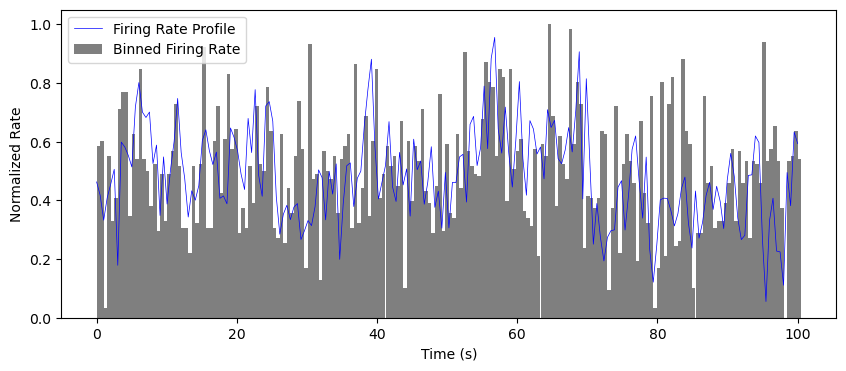

In [50]:
# Normalize the fr_profile and mean_firing_rate to [0, 1]
norm_fr_profile = (fr_profile - np.min(fr_profile)) / (np.max(fr_profile) - np.min(fr_profile))
norm_mean_firing_rate = (mean_firing_rate - np.min(mean_firing_rate)) / (np.max(mean_firing_rate) - np.min(mean_firing_rate))

# If norm_fr_profile has different length, you can interpolate it to match num_bins
from scipy.interpolate import interp1d

# Generate the 'x' values for the existing fr_profile
old_x = np.linspace(0, tstop, len(norm_fr_profile))

# Create an interpolation function based on the existing data
interp_func = interp1d(old_x, norm_fr_profile)

# Create the new 'x' values and use the interpolation function to generate 'y' values
new_x = np.linspace(0, tstop, num_bins)
new_norm_fr_profile = interp_func(new_x)

# Now plot
plt.figure(figsize=(10, 4))

# Plot the binned firing rate
plt.bar(new_x, norm_mean_firing_rate, width=bin_size, align='edge', alpha=0.5, label='Binned Firing Rate', color='black')

# Plot the firing rate profile
plt.plot(new_x, new_norm_fr_profile, linewidth=0.5, label='Firing Rate Profile', color='blue')

plt.xlabel("Time (s)")
plt.ylabel("Normalized Rate")
plt.legend()
plt.show()

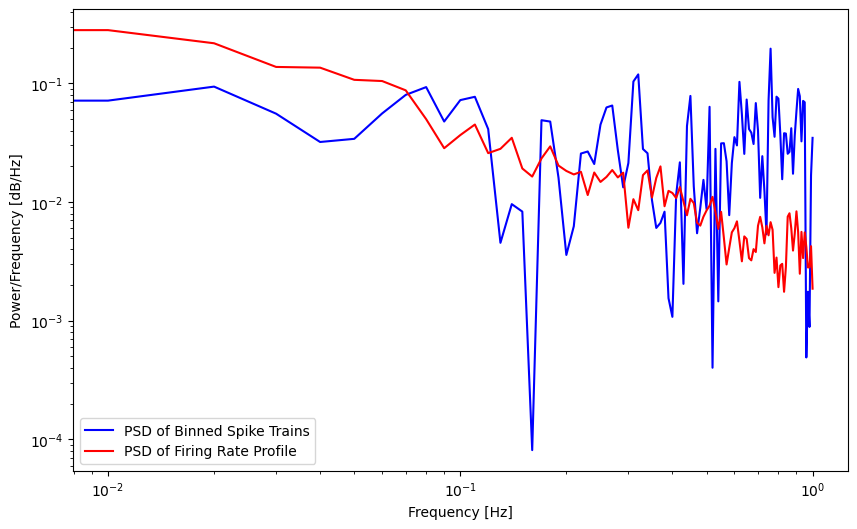

In [51]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Make sure that the nperseg parameter is smaller than or equal to the length of your data arrays
nperseg_value = min(256, len(norm_mean_firing_rate), len(norm_fr_profile))

# Compute the PSDs
frequencies1, psd_mean_firing_rate = signal.welch(norm_mean_firing_rate, fs=1/bin_size, nperseg=nperseg_value)
frequencies2, psd_fr_profile = signal.welch(norm_fr_profile, fs=1/bin_size, nperseg=nperseg_value)

# Make sure frequencies1 and frequencies2, and psd_mean_firing_rate and psd_fr_profile have the same lengths
assert len(frequencies1) == len(frequencies2)
assert len(psd_mean_firing_rate) == len(psd_fr_profile)

# Now plot
plt.figure(figsize=(10, 6))
plt.loglog(frequencies1, psd_mean_firing_rate, label='PSD of Binned Spike Trains', color='b')
plt.loglog(frequencies2, psd_fr_profile, label='PSD of Firing Rate Profile', color='r')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.legend()
plt.show()

Testing version where mean_fr is not stagnant and checking frequency calculation, depth_of_mod effect

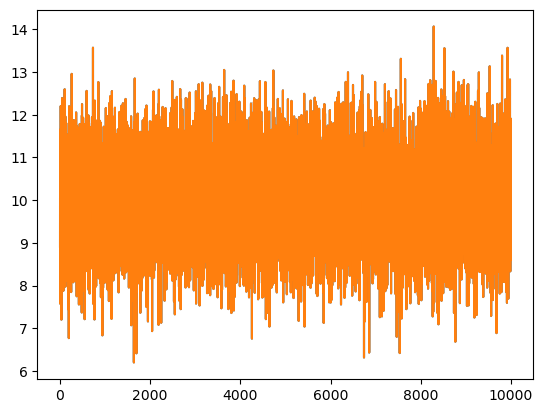

In [52]:
import numpy as np
import matplotlib.pyplot as plt
num_points = 10000 # samples
delta_t = 0.1 # ms
noise_mean = 0 # added to lambdas
noise_std = 1
lambdas_mean = 10
frequency = 5 # hz
# frequency = (frequency) * (num_points*delta_t / 1000)
depth_of_mod = 0
assert 0<=depth_of_mod<=1
noise = np.random.normal(noise_mean, noise_std, num_points)  # mean, std, num_points
lambdas = [lambdas_mean for i in range(num_points)]
lambdas = lambdas + noise
plt.plot(lambdas)
# t = np.linspace(0, 1, len(lambdas))
t = np.linspace(0, num_points * delta_t * 1e-3, num_points) # Time array in seconds
lambdas_mod = lambdas + lambdas * depth_of_mod * np.sin(2 * np.pi * frequency * t)
plt.plot(lambdas)

In [53]:
# check if depth_of_mod = 0 is the same as no modulation
sum(lambdas_mod == lambdas) == num_points

True